Generated data according to a random effects linear regression model:

$i \in \{1,...,n_i = 20\}$, $j \in \{1,...,p = 4\}$, $\boldsymbol\beta = (3,8)^T$, $\sigma^2 = 1$, $\Omega \sim \text{InvWishart}(2.1, I_2/2.1)$

$$\boldsymbol\alpha_{i} = (\alpha_{i,1}, \alpha_{i,2})^T \overset{iid}{\sim} N(\boldsymbol\beta, \boldsymbol\Omega) $$

$$Y_{i,j} \, | \, \boldsymbol\alpha_i \sim N(\alpha_{i,1} + \alpha_{i,2}x_j, \sigma^2) $$

The cell below generates this data set. 

In [1]:
rm(list = ls())
set.seed(1927)
library(mvtnorm)

#data
ni = 20; p = 4
x = (runif(p,0,1)); #predictor at each level

#true sig2, true beta that generated alpha_i, true Omega
sig2_true = 1
beta_true = c(3,8)
Omega_true = matrix(c(1,-0.5,-0.5,2),ncol = 2)
#Omega_true
#generate true alpha_i
alpha_true = rmvnorm(ni,beta_true,diag(1,2))
#generate y
y = matrix(NA,nrow = ni, ncol = p)
for (i in 1:ni){
    y[i,] = rnorm(p,alpha_true[i,1] + alpha_true[i,2]*x,sig2_true)
}

Next, we set our prior parameters and initialize some variables for our Gibbs samplier:

In [2]:
#prior parameters
a = b = 0.1 #hyperparameters for sig2
v0 = 2.1; A0 = matrix(c(1/2.1,0,0,1/2.1), ncol = 2); #hyperparameters for Omega
mu0 = c(0,0); Omega0 = 100^2*diag(1,2);  #hyperparameters for beta

In [3]:
#inital values and upfront calculations
n.iters = 2000
beta0 = c(0,0) #initial values for beta chain
alpha0 = c(0,0) #initial values for alpha chain
sig2 = 0.1 #initial values for sig2 chain
intercepts = matrix(0,n.iters,ni) #initialize MCMC matrix for intercepts
slopes = matrix(0,n.iters,ni) #initialize MCMC matrix for slopes
beta_mcmc = matrix(0,n.iters,2) #initialize MCMC matrix for population means
sig2_mcmc = matrix(sig2,n.iters,1) #initialize MCMC vector for sig2

Omega0_inv = solve(Omega0) #initial values for Omega_inv

#upfront data and gram matrices
X = cbind(1,x); 
gram = t(X)%*%X; 


And now, the Gibbs samplier!

In [4]:
set.seed(4929)
Omega_inv =  Omega0_inv
beta = beta0
Omega_sum = matrix(0,ncol = 2, nrow = 2)


for(i.gibbs in 2:n.iters){
    alpha_i = matrix(NA,ni,2) 
    s = 0 #part of sig2 calculation
    #alpha_i | .
    for (i in 1:ni){
        S2 = sig2*solve(Omega_inv + gram)
        M = 1/sig2*S2%*%(Omega_inv%*%beta + t(X)%*%y[i,])
        alpha_i[i,] = rmvnorm(1,M,S2)
        intercepts[i.gibbs,i] = as.vector(t(alpha_i[i,1]))
        slopes[i.gibbs,i] = as.vector(t(alpha_i[i,2]))
        #for sig2 update:
        s = s + sum((y[i,] - alpha_i[i,1] - alpha_i[i,2]*x)^2) #used in sig2 update
    }
    
    #beta | .
    S2 = solve(Omega0_inv + ni*Omega_inv)
    M = S2%*%(Omega0_inv%*%mu0 + ni*Omega_inv%*%colMeans(alpha_i))
    beta = t(rmvnorm(1,M,S2))
    beta_mcmc[i.gibbs,] = beta
    
    #sig2 | .
    A = ni*p/2 + a
    for (i in 1:ni){ }
    B =  s/2 + b 
    sig2 = 1/rgamma(1,A,B)
    sig2_mcmc[i.gibbs] = sig2
    
    #Omega | .
    one = ni + v0; 
    A1 = matrix(0,ncol = 2, nrow  = 2); 
    for (i in 1:ni) A1 = A1 + (alpha_true[i,] - beta_true)%*%t(alpha_true[i,] - beta_true)
    A1 = solve(A0) + A1
    Omega_inv = matrix(rWishart(1,one,solve(A1)), ncol = 2, nrow = 2)
    Omega_sum = Omega_sum + solve(Omega_inv) #running sum
}

0.7531915,-0.2361491
-0.2361491,0.5755260


1.0,-0.5
-0.5,2.0


[1] 1.296791

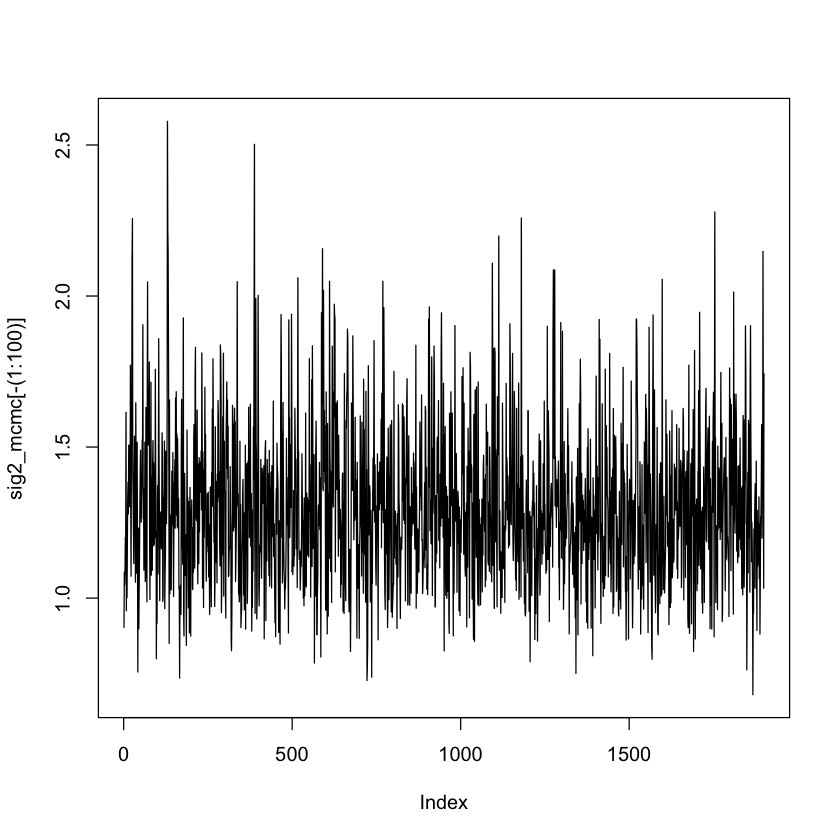

In [5]:
#head(cbind(colMeans(slopes),alpha_true[,2]))
#head(cbind(colMeans(intercepts),alpha_true[,1]))
#head(beta_mcmc)
Omega_hat = (Omega_sum/n.iters)
Omega_hat
Omega_true

#solve(Omega_inv_sum/n.iters)
plot(sig2_mcmc[-(1:100)], type = "l")
mean(sig2_mcmc[-(1:100)])

From the posterior mean of the covariance matrix, $E(\Omega | \mathbf{y} )$, we can obtain an estimate of $$\text{Cor}\left(\alpha_{i,1}, \alpha_{i,2}\right) = \frac{\Omega_{1,2}}{\sqrt{\Omega_{1,1}\Omega_{2,2}}} \approx -0.359$$. We see that this is a good estimate of the true correlation (obtained from the true $\Omega$). 

Therefore, there is a negative dependence between the intercept and the slope, indiciating that the response increases for individuals with low values of the response

In [6]:
Omega_true[1,2]/sqrt(Omega_true[1,1]*Omega_true[2,2])
Omega_hat[1,2]/sqrt(Omega_hat[1,1]*Omega_hat[2,2])

[1] -0.3535534

[1] -0.3586751